<a href="https://colab.research.google.com/github/Singhsansar/Covid-Knowledge-Graph/blob/main/capturing_the_temporal_relationships.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

!pip install neo4j
!pip install py2neo

In [4]:
from neo4j import GraphDatabase
uri = "bolt://3.231.19.55:7687"
username = "neo4j"
password = "hearts-wire-swaps"
driver = GraphDatabase.driver(uri, auth=(username, password))

In [5]:
def insert_into_graph_database(source, target, label, temp_relation):
    create_node_query = "CREATE (n:Node {id: $id, label: $label})"

    create_relationship_query = (
        "MATCH (source:Node {id: $source_id}), (target:Node {id: $target_id}) "
        "CREATE (source)-[:RELATIONSHIP {label: $label, temporal_relation: $temp_relation, weight: 1}]->(target), "
        "(source)<-[:RELATIONSHIP {label: $label, temporal_relation: $temp_relation, weight: 1}]-(target)"
    )

    try:
        with driver.session() as session:
            # Create nodes
            session.run(create_node_query, id=source, label=label)
            session.run(create_node_query, id=target, label=label)

            # Create relationships
            session.run(create_relationship_query, source_id=source, target_id=target, label=label, temp_relation=temp_relation)

        print("Nodes and relationships inserted successfully.")
    except Exception as e:
        print(f"Error during insertion: {e}")


In [12]:
import json
with open('output.json', 'r') as file:
    data = json.load(file)

i = 0
for relationship in data:
    source = relationship['source']
    label = relationship['label']
    target = relationship['target']
    temp_relation= relationship['temporal_relation']

    insert_into_graph_database(source,target,label,temp_relation)
    break

<ipython-input-5-fa21ec185446>:11: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


Nodes and relationships inserted successfully.


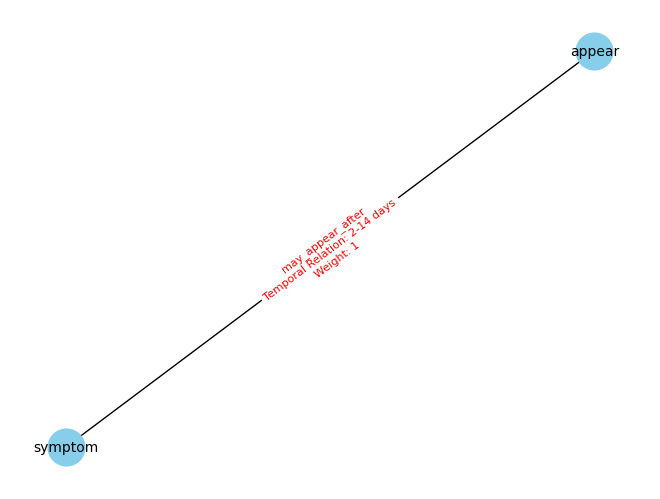

In [17]:
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import networkx as nx
from py2neo import Graph

uri = "bolt://3.231.19.55:7687"
username = "neo4j"
password = "hearts-wire-swaps"
driver = GraphDatabase.driver(uri, auth=(username, password))

def retrieve_graph_data():
    graph = nx.Graph()
    with driver.session(database="neo4j") as session:
        result = session.run("MATCH (n)-[r]->(m) RETURN n, r, m")
        for record in result:
            source = record["n"]
            target = record["m"]
            relation = record["r"]

            graph.add_node(source["id"], label=source["label"])
            graph.add_node(target["id"], label=target["label"])
            graph.add_edge(source["id"], target["id"], relation=relation["label"], temporal_relation=relation["temporal_relation"], weight=relation["weight"])
    return graph

def visualize_graph(graph, edge_length=1.0):
    pos = nx.spring_layout(graph, k=edge_length)

    labels = {(i, j): f"{graph[i][j]['relation']}\nTemporal Relation: {graph[i][j]['temporal_relation']}\nWeight: {graph[i][j]['weight']}" for i, j in graph.edges()}

    nx.draw(graph, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_color='red', font_size=8)

    plt.show()

# Example usage
graph_data = retrieve_graph_data()
visualize_graph(graph_data, edge_length=0.5)
driver.close()


In [11]:
from neo4j import GraphDatabase
uri = "bolt://3.231.19.55:7687"
username = "neo4j"
password = "hearts-wire-swaps"
driver = GraphDatabase.driver(uri, auth=(username, password))

# Function to delete nodes and relationships
def delete_nodes_and_relationships():
    with driver.session() as session:
          session.run("MATCH (n) DETACH DELETE n")

# Call the function to delete everything
delete_nodes_and_relationships()
driver.close()

In [15]:
from py2neo import Graph

uri = "bolt://3.231.19.55:7687"
username = "neo4j"
password = "hearts-wire-swaps"

graph = Graph(uri, auth=(username, password))

cypher_query = """
MATCH (source:Node)-[relation:RELATIONSHIP]->(target:Node)
RETURN source.id AS source_id, source.label AS source_label,
       relation.label AS relationship_label, relation.temporal_relation AS temporal_relation, relation.weight AS relationship_weight,
       target.id AS target_id, target.label AS target_label
"""

result = graph.run(cypher_query)

for record in result:
    print(f"Source Node: {record['source_id']} ({record['source_label']})")
    print(f"Relationship: {record['relationship_label']} (Temporal Relation: {record['temporal_relation']}, Weight: {record['relationship_weight']})")
    print(f"Target Node: {record['target_id']} ({record['target_label']})")
    print("-" * 40)


Source Node: symptom (may_appear_after)
Relationship: may_appear_after (Temporal Relation: 2-14 days, Weight: 1)
Target Node: appear (may_appear_after)
----------------------------------------
Source Node: appear (may_appear_after)
Relationship: may_appear_after (Temporal Relation: 2-14 days, Weight: 1)
Target Node: symptom (may_appear_after)
----------------------------------------
